## Цель

Для проекта "Если быть точным" https://tochno.st/  

* Увеличить сумму ежемесячных пожертвований на «Если быть точным» до 60 000 рублей.
* Увеличить количество заявок на верификацию НКО до 32.

## Гипотеза


Используя методологию приоритезации гипотез ICE мы выбрали гипотезу, по увеличению конверсии из посещений в Email.

Конверсия за последние 3 месяца составляет 0,85 %

```
Если видоизменить сайт: добавить всплывающее окно с предложением оформить e-mail рассылку, сверху страницы сайта закрепить кнопку с предложением оформить e-mail рассылку и изменить дизайн самой формы подписки, то конверсия в подписку возрастет на 150%
```

Используя калькулятор https://www.evanmiller.org/ab-testing/sample-size.html мы расчитали, чтобы подтвердить результат эксперимента нам нужно 1000 пользователей в каждом из вариантов.

Чтобы получить выборку такого размера на этом сайте мы должны проводить эксперимент 2 недели. 

Эксперимент поставлен с помощью Google Optimize.



In [44]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import shuffle
from statsmodels.stats.weightstats import ztest
from matplotlib import pyplot
from scipy.stats import shapiro
from scipy.stats import boxcox

data = pd.read_csv("PA_15_ab_test_results.csv")
print("Данные эксперимента загружены")
data.head(5)

Данные эксперимента загружены


,Day Index,Users,Email Subscriptions,Group Type
0,08/07/20,170,1,control
1,08/07/20,142,3,test
2,09/07/20,100,1,control
3,09/07/20,95,5,test
4,10/07/20,170,2,control


In [45]:
grouped = data.groupby('Group Type').sum().reset_index()
data['conversion'] = data['Email Subscriptions']*100/data['Users']
grouped['conversion'] = grouped['Email Subscriptions']*100/grouped['Users']
all_users = data['Users'].sum()
control_users = data[data['Group Type'] == 'control']['Users'].sum()
test_users = data[data['Group Type'] == 'test']['Users'].sum()
control_subscribers = data[data['Group Type'] == 'control']['Email Subscriptions'].sum()
test_subscribers = data[data['Group Type'] == 'test']['Email Subscriptions'].sum()
control_cr = control_subscribers/control_users
test_cr = test_subscribers/test_users


print('Всего пользователей в эксперименте:', all_users)
print('Конверсия в тестовой группе выше на:', round(test_cr/control_cr, 2))
print('Сводка по эксперименту:')
grouped

Всего пользователей в эксперименте: 5139
Конверсия в тестовой группе выше на: 2.53
Сводка по эксперименту:


,Group Type,Users,Email Subscriptions,conversion
0,control,2476,18,0.726979
1,test,2663,49,1.840030


## Считаем доверительный интервал

Считаем при помощи калькулятора https://sample-size.net/confidence-interval-proportion/

### Для контрольной группы

Proportion of positive results = P = x/N = 0.0073

Lower bound = 0.0043

Upper bound = 0.0115

### Для тестовой группы 

Proportion of positive results = P = x/N = 0.0184

Lower bound = 0.0136

Upper bound = 0.0243

Если использовать нижнюю границу интервала для тестовой группы и верхнюю границу для контрольной мы получаем рост в 118%, это меньше чем 150%, но рост виден. Попробуем использовать другие методы для подтверждения нашей гипотезы.


In [46]:
def generate_zdata(sample_size, converted_size):
    res = [1]*converted_size + [0]*(sample_size - converted_size)
    shuffle(res)
    return res

statistic, p_value = ztest(generate_zdata(control_users, control_subscribers),
                          generate_zdata(test_users, test_subscribers))

print(f"statistic: {statistic}")
print(f"p_value: {p_value}")


statistic: -3.518247192651825
p_value: 0.0004344075051461056


## Z Оценка

Информация о Z оценке.

https://desktop.arcgis.com/ru/arcmap/10.3/tools/spatial-statistics-toolbox/what-is-a-z-score-what-is-a-p-value.htm

Чтобы подтвердить или опровергнуть гипотезу я воспользовался методом z оценки. Для этого я преобразовал данные в списки бинарных данных.

Я получил высокое значение статистики(3,52) и крайне низкий p-value(0.0004). 
Значение p-value позволяет нам отвергнуть нулевую гипотезу, с очень высокой долей вероятности наблюдаемая разница в цифрах - это не результат случайности.

Для большей уверенности проведем исследование распределения на нормальность и применим соответсвующие методики для оценки.

In [47]:
conv1 = [1]*18 + [0]*(2476-18)
conv2 = [1]*49 + [0]*(2663 - 49)

from statsmodels.stats.weightstats import ztest
statistic, p_value = ztest(conv1, conv2)

print(f"statistic: {statistic}")
print(f"p_value: {p_value}")

statistic: -3.518247192651825
p_value: 0.0004344075051461056


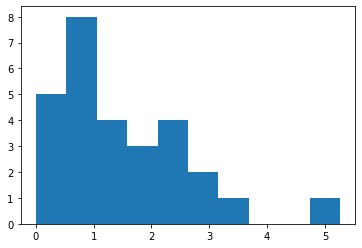

stat=0.886634349822998, p-value=0.005643473006784916
Можно отвергнуть гипотезу о нормальном распределении, распределение не Gaussian


In [48]:
pyplot.hist(data['conversion'], bins=10)
pyplot.show()

stat, p_value = shapiro(data['conversion'])

print(f'stat={stat}, p-value={p_value}')
alpha = 0.05
if p_value > alpha:
    print('Нельзя отвергнуть гипотезу о нормальном распределении, распределение Gaussian')
else:
    print('Можно отвергнуть гипотезу о нормальном распределении, распределение не Gaussian')

## Бутстреп сэмплирование

100%|██████████| 10000/10000 [00:00<00:00, 21918.17it/s]


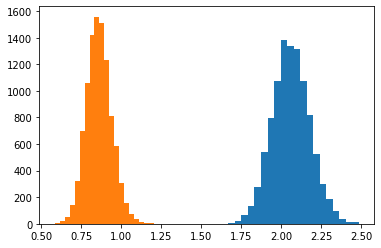

In [51]:
np.random.seed(1)
all_values_test =  data[data['Group Type'] == 'test']['conversion'].values.tolist()
all_values_control =  data[data['Group Type'] == 'control']['conversion'].values.tolist()

sample_mean_test = []
sample_mean_control = []

for i in tqdm(range(10000)):
    sample_n = np.random.choice(all_values_test, size=100)
    sample_mean_test.append(sample_n.mean())

    sample_n = np.random.choice(all_values_control, size=100)
    sample_mean_control.append(sample_n.mean())


pyplot.hist(sample_mean_test, bins=20)
pyplot.hist(sample_mean_control, bins=20)
pyplot.show()

## Вывод по бутстреп сэмплированию

Поскольку мы отвергли нормальность распределения данных. Был использован метод бутсреп семплирования для сравнения выборок. Суть метода заключается в том, что мы многократно из выборки случайным образовым выбираем данные и усредняем их. Создается выборка из средних многократных выборок. 

В такой выборке значения будут стремиться к истинному среднему всей совокнупности. 


Из графиков видно, что распределение в разных сэмплах стремится к разным средним величинам. 

Гипотезу по улучшению конверсии мы подтвердии.

# Вывод

Гипотеза по улучшению конверсии мы подтвердили. Рекоммендуем раскатывать результа на всю совокупность.

Исходя из доверительного интервала

Lower bound = 0.0136

Upper bound = 0.0243

и конверсии за предыдущий период в 0,0085% можем предположить:


Минимальный возможный рост конверсии: 1,6 раз
Максимальный возможный рост конверсии: 2,86 раз

## Вопросы ментору.

1. Как понять когда остановится в подтверждениях? Достаточно ли p_value, когда нужно считать дальше? 
2. Если математика и статистика - мое слабое место. Как максимально быстро развить эти навыки?
3. Есть онлайн сервис имеет 90 регистраций в месяц, конверсия в 30 оплат. Есть триальный период. На триале около 100 пользователей одновременно. Как можно проводить а/б тесты в таких условиях? Как ставить эксперименты? Нормально ли сравнивать данные с прошлыми периодами?
4. Где найти ментора, с которым можно советоваться по своему проекту и давать на ревью результаты работы?